In [1]:
import warnings
warnings.filterwarnings("ignore")
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
tf.debugging.set_log_device_placement(True)

In [2]:
data_dir = "../data"
os.listdir(data_dir)

['sample_submission.csv', 'test', 'train']

In [3]:
N, H, W, C = 32, 224, 224, 3

In [5]:
dataset_size = len(list(Path(data_dir + "/train").glob('*/*')))
test_image_count = len(list(Path(data_dir + "/test").glob('*')))
train_image_count = int(0.95 * dataset_size)
val_image_count = int(0.05 * dataset_size)
print(train_image_count)
print(val_image_count)
print(test_image_count)

832
43
610


In [6]:
all_data = tf.data.Dataset.list_files(str(data_dir + "/train/" +'*/*'))
all_data = all_data.shuffle(1000)
train_list_ds = all_data.take(train_image_count)
val_list_ds = all_data.take(val_image_count)
# train_list_ds = tf.data.Dataset.list_files(str(data_dir + "/train/" +'*/*'))
test_list_ds = tf.data.Dataset.list_files(str(data_dir + "/test/" +'*'))

Executing op MatchingFiles in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Greater in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReduceJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Maximum in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job

In [7]:
CLASS_NAMES = np.array([item.name for item in Path(data_dir + "/train").glob('*')])
CLASS_NAMES

array(['healthy_wheat', 'leaf_rust', 'stem_rust'], dtype='<U13')

In [8]:
for f in train_list_ds.take(5):
  print(f.numpy())

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0
b'..\\data\\train\\stem_rust\\RQF5OM.jpg'
b'..\\data\\train\\leaf_rust\\5PNZRU.jfif'
b'..\\data\\train\\healthy_wheat\\JNFAO1.jpg'
b'..\\data\\train\\leaf_rust\\V35M9N.jfif'
b'..\\data\\train\\stem_rust\\IHTFG4.JPG'
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


In [4]:
def show_batch(img, label):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(img[n])
        plt.title(CLASS_NAMES[label[n] == 1][0].title())
        plt.axis('off')

In [9]:
def read_image(img_path):
    img_loader = tf.io.read_file(img_path)
    img_decoder = tf.image.decode_jpeg(img_loader, channels=C)
    img = tf.image.convert_image_dtype(img_decoder, tf.float32)
    img = tf.image.resize(img, [W, H])
    return img

In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [11]:
def process_path(file_path):
    label = get_label(file_path)
    img = read_image(file_path)
    return img, label

In [12]:
train_labeled_ds = train_list_ds.map(process_path, num_parallel_calls=-1)
val_labeled_ds = val_list_ds.map(process_path, num_parallel_calls=-1)

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=100, training=True):
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  if training:
    ds = ds.repeat()
    print("repeating")
  else:
    pass
  ds = ds.batch(N)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=-1)

  return ds

In [13]:
for image, label in train_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0
Image shape:  (224, 224, 3)
Label:  [False False  True]


In [15]:
train_ds = prepare_for_training(train_labeled_ds)
val_ds = prepare_for_training(val_labeled_ds, training=False)
image_batch, label_batch = next(iter(train_ds))

Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
repeating
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0


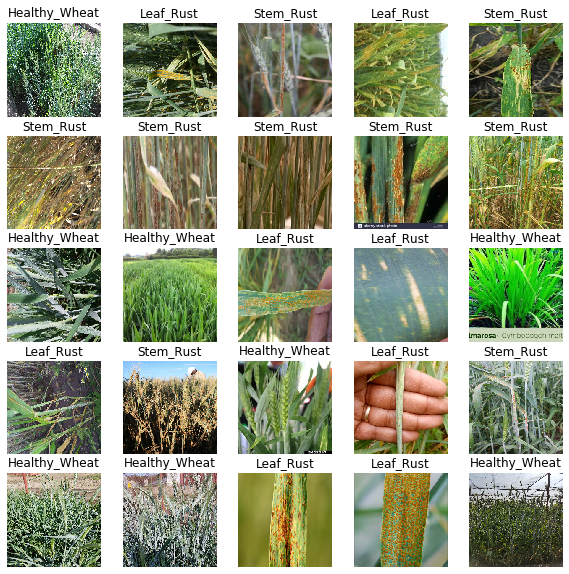

In [16]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [17]:
test_list = "../data/test"
test_list_ds = tf.data.Dataset.list_files(str(test_list +'*/*'))
for f in test_list_ds.take(5):
  print(f.numpy())

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
b'..\\data\\test\\8WTRO2.jfif'
b'..\\data\\test\\66BJ7B.jpg'
b'..\\data\\test\\65ZIX2.jfif'
b'..\\data\\test\\3RITFB.jfif'
b'..\\data\\test\\7VKX0H.jfif'


In [18]:
def process_test(image_path):
    img = read_image(image_path)
    return img, image_path
    
test_ds = test_list_ds.map(process_test, num_parallel_calls=-1)

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0
(224, 224, 3)
b'..\\data\\test\\V9HEG6.jpg'


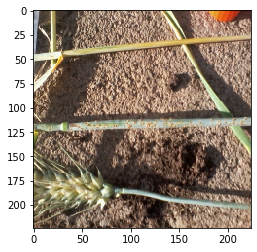

In [19]:
for i, j in test_ds.take(1):
    print(i.numpy().shape)
    print(j.numpy())
    plt.imshow(i.numpy())

In [20]:
# define class weights
leaf_rust_count = 358
stem_rust_count = 376
healthy_wheat_count = 142
total = leaf_rust_count + stem_rust_count + healthy_wheat_count

leaf_rust_weight = (1/leaf_rust_count) * (total) / 3.0
stem_rust_weight = (1/stem_rust_count) * (total) / 3.0
healthy_wheat_weight = (1/healthy_wheat_count) * (total) / 3.0

class_weight = {0:leaf_rust_weight, 1:stem_rust_weight, 2:healthy_wheat_weight}
print(class_weight)

{0: 0.8156424581005587, 1: 0.776595744680851, 2: 2.056338028169014}


In [21]:
IMG_SHAPE = (H, W, C)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [22]:
base_model.trainable = False

In [23]:
pretrained_model = tf.keras.Sequential([
base_model,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(256, activation="relu"),
tf.keras.layers.Dense(3, activation="softmax")
])

pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics = [tf.keras.metrics.categorical_accuracy])

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [24]:
pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 58,856,963
Trainable params: 525,315
Non-trainable params: 58,331,648
_________________________________________________________________


In [25]:
steps_per_epoch = train_image_count // N
val_steps = val_image_count//N

In [26]:
pretrained_model.fit(train_ds,
                     epochs=20,
                     steps_per_epoch=steps_per_epoch,
                     validation_data=val_ds,
                     validation_steps=val_steps)

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Train for 26 steps, validate for 1 steps
Epoch 1/20
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /j